#### 导入运行demo所需要的库

In [1]:
import os, shutil
import numpy as np
import random
import matplotlib.pyplot as plt
from cellpose import core, utils, io, models, metrics
from glob import glob
import cv2
import tifffile as tif

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

#### 根据Kmeans找出的中心点，划分数据集

In [2]:
# 返回图片在hsv通道的均值和方差作为特征
def extract_feature(image_path: str):
    feature = []
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img_hsv=cv2.cvtColor(img,cv2.COLOR_BGR2HSV)

    means_hsv, std_hsv = cv2.meanStdDev(img_hsv)

    feature.append(means_hsv)
    feature.append(std_hsv)
    return feature

# 根据已经得到的中心点坐标，返回对应的类别
def cluster(image_path:str):
    # centroids =  np.array([[ 3.68690462e+00,4.91377476e-01,1.05816313e+02,6.40730387e-01, 6.33847919e-01, 3.30937372e+01], 
    # [ 8.83080468e+01, 6.42774511e+01, 1.88746883e+02, 5.20849872e+01 ,6.21139065e+01, 6.56514354e+01],
    # [ 3.26645650e+01, 9.62089421e+01, 2.83977459e+01, 4.37860448e+01, 1.18951032e+02, 4.94940273e+01],
    # [-9.23705556e-14, 2.48689958e-14, 2.80961654e+01 ,4.97379915e-14, 2.84217094e-14, 4.35067791e+01]])
    centroids =  np.array([[  3.68690462,   0.49137748, 105.81631272,   0.64073039,   0.63384792, 33.09373723],
    [ 88.30804682  ,64.27745113, 188.7468829 ,  52.08498724,  62.11390647, 65.65143542],
    [ 43.63164599 ,111.92362705 , 50.05808066,  37.31790109,  81.6843576, 64.13352828],
    [-9.23705556e-14 ,2.48689958e-14 ,2.80961654e+01, 4.97379915e-14, 2.84217094e-14, 4.35067791e+01]])
    feature = extract_feature(image_path=image_path)
    feature = np.array(feature)
    feature = feature[:,:,0]
    feature = feature.reshape(feature.shape[0]*feature.shape[1])

    distance = np.zeros(len(centroids))

    for i in range(len(centroids)):
        distance[i] = np.sqrt(np.sum((feature - centroids[i]) ** 2))
    label = np.argmin(distance)
    return label

#### 数据预处理部分
- 整理数据
- 根据kmeans的聚类划分数据集

In [3]:
img_dir = '/data112/wzy/NIPS/data/Train_Pre_3class/images'
label_dir = '/data112/NeurISP2022-CellSeg/Train-Labeled/labels'
root_dir = '/data112/wzy/NIPS/data/Train_Pre_3class/cluster'

imgs_path = os.listdir(img_dir)
imgs_path.sort()
imgs_path = imgs_path[1:]
random.shuffle(imgs_path)

for i,img_path in enumerate(imgs_path):
    img_name = img_path.split('.')[0]
    img = cv2.imread(os.path.join(img_dir,img_path),-1)
    mask = cv2.imread(os.path.join(label_dir,(img_name + '_label.tiff')),-1)
    print(img_name)

    label = cluster(os.path.join(img_dir,img_path))
    cv2.imwrite(os.path.join(root_dir,'class_{}'.format(label),(img_name + '.png')),img)
    cv2.imwrite(os.path.join(root_dir,'class_{}'.format(label),(img_name + '_label.png')),mask)


cell_00574
cell_00077
cell_00230
cell_00772
cell_00148
cell_00404
cell_00917
cell_00927
cell_00154
cell_00887
cell_00596
cell_00060
cell_00955
cell_00969
cell_00164
cell_00854
cell_00669
cell_00110
cell_00163
cell_00974
cell_00076
cell_00245
cell_00537
cell_00705
cell_00736
cell_00859
cell_00438
cell_00457
cell_00105
cell_00770
cell_00639
cell_00410
cell_00478
cell_00267
cell_00204
cell_00044
cell_00300
cell_00365
cell_00087
cell_00981
cell_00524
cell_00422
cell_00551
cell_00577
cell_00463
cell_00849
cell_00120
cell_00710
cell_00072
cell_00769
cell_00307
cell_00755
cell_00415
cell_00785
cell_00746
cell_00040
cell_00450
cell_00347
cell_00488
cell_00913
cell_00238
cell_00644
cell_00676
cell_00402
cell_00487
cell_00051
cell_00219
cell_00987
cell_00530
cell_00547
cell_00856
cell_00668
cell_00048
cell_00194
cell_00158
cell_00094
cell_00065
cell_00470
cell_00412
cell_00842
cell_00672
cell_00391
cell_00821
cell_00326
cell_00793
cell_00002
cell_00416
cell_00834
cell_00119
cell_00681
cell_00780

#### 设置模型通用的超参

In [3]:
initial_model = "cyto"
n_epochs = 30
Channel_to_use_for_training = "Green"
Second_training_channel= "None"
Use_Default_Advanced_Parameters = True
learning_rate = 0.1 
weight_decay = 0.0001
model_path = '/data112/wzy/NIPS/baseline/work_dir/cellpose'

# 用于判断拿出哪一个通道去进行分割
if Channel_to_use_for_training == "Grayscale":
  chan = 0
elif Channel_to_use_for_training == "Blue":
  chan = 3
elif Channel_to_use_for_training == "Green":
  chan = 2
elif Channel_to_use_for_training == "Red":
  chan = 1


if Second_training_channel == "Blue":
  chan2 = 3
elif Second_training_channel == "Green":
  chan2 = 2
elif Second_training_channel == "Red":
  chan2 = 1
elif Second_training_channel == "None":
  chan2 = 0

#### 定义模型并训练

In [5]:
for i in range(4):
    train_dir = "/data112/wzy/NIPS/data/Train_Pre_3class/cluster/class_{}".format(i)
    test_dir = "/data112/wzy/NIPS/data/Train_Pre_3class/cluster/class_{}".format(i)
    model_name = "cellpose_cluster_v{}".format(i)
    # start logger (to see training across epochs)
    logger = io.logger_setup()

    # DEFINE CELLPOSE MODEL (without size model)
    model = models.CellposeModel(gpu=True, model_type=initial_model)

    # set channels
    channels = [chan, chan2]

    # get files
    output = io.load_train_test_data(train_dir, test_dir, mask_filter='_label')
    train_data, train_labels, _, test_data, test_labels, _ = output

    new_model_path = model.train(train_data, train_labels, 
                                test_data=test_data,
                                test_labels=test_labels,
                                channels=channels, 
                                save_path=train_dir, 
                                n_epochs=n_epochs,
                                learning_rate=learning_rate, 
                                weight_decay=weight_decay, 
                                nimg_per_epoch=8,
                                model_name=model_name)

    # diameter of labels in training images
    diam_labels = model.diam_labels.copy()

2022-09-11 20:30:36,901 [INFO] WRITING LOG OUTPUT TO /home/wzy/.cellpose/run.log
2022-09-11 20:30:36,902 [INFO] >> cyto << model set to be used
2022-09-11 20:30:43,986 [INFO] ** TORCH CUDA version installed and working. **
2022-09-11 20:30:43,995 [INFO] >>>> using GPU
2022-09-11 20:30:44,180 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2022-09-11 20:30:44,358 [INFO] not all flows are present, running flow generation for all images
2022-09-11 20:31:07,156 [INFO] 311 / 311 images in /data112/wzy/NIPS/data/Train_Pre_3class/cluster/class_0 folder have labels
2022-09-11 20:31:07,184 [INFO] not all flows are present, running flow generation for all images
2022-09-11 20:31:29,707 [INFO] 311 / 311 images in /data112/wzy/NIPS/data/Train_Pre_3class/cluster/class_0 folder have labels
2022-09-11 20:32:50,846 [INFO] computing flows for labels


 93%|█████████▎| 289/311 [01:43<00:04,  4.51it/s]

2022-09-11 20:34:35,584 [WARNING] empty masks!


100%|██████████| 311/311 [01:45<00:00,  2.96it/s]


2022-09-11 20:35:38,435 [INFO] computing flows for labels


 93%|█████████▎| 289/311 [01:37<00:05,  4.40it/s]

2022-09-11 20:37:16,737 [WARNING] empty masks!


100%|██████████| 311/311 [01:38<00:00,  3.15it/s]


2022-09-11 20:37:53,428 [WARNING] 1 train images with number of masks less than min_train_masks (5), removing from train set


/home/wzy/.conda/envs/open-mmlab/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/wzy/.conda/envs/open-mmlab/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


2022-09-11 20:38:19,045 [INFO] >>>> median diameter set to = 30
2022-09-11 20:38:19,047 [INFO] >>>> mean of training label mask diameters (saved to model) 45.290
2022-09-11 20:38:19,050 [INFO] >>>> training network with 2 channel input <<<<
2022-09-11 20:38:19,051 [INFO] >>>> LR: 0.10000, batch_size: 8, weight_decay: 0.00010
2022-09-11 20:38:19,052 [INFO] >>>> ntrain = 310, ntest = 311
2022-09-11 20:38:19,054 [INFO] >>>> nimg_per_epoch = 310
2022-09-11 20:38:43,808 [INFO] Epoch 0, Time 24.8s, Loss 0.9472, Loss Test 0.8818, LR 0.0000
2022-09-11 20:38:56,109 [INFO] saving network parameters to /data112/wzy/NIPS/data/Train_Pre_3class/cluster/class_0/models/cellpose_cluster_v0
2022-09-11 20:39:57,900 [INFO] Epoch 5, Time 98.8s, Loss 0.3511, Loss Test 0.2765, LR 0.0556
2022-09-11 20:41:08,577 [INFO] Epoch 10, Time 169.5s, Loss 0.2798, Loss Test 0.2507, LR 0.1000
2022-09-11 20:43:16,890 [INFO] Epoch 20, Time 297.8s, Loss 0.2297, Loss Test 0.2069, LR 0.1000
2022-09-11 20:45:04,040 [INFO] savi

100%|██████████| 270/270 [04:29<00:00,  1.00it/s]


2022-09-11 20:53:05,709 [INFO] computing flows for labels


100%|██████████| 270/270 [04:28<00:00,  1.01it/s]


2022-09-11 20:58:55,672 [WARNING] 2 train images with number of masks less than min_train_masks (5), removing from train set
2022-09-11 20:59:33,681 [INFO] >>>> median diameter set to = 30
2022-09-11 20:59:33,683 [INFO] >>>> mean of training label mask diameters (saved to model) 147.525
2022-09-11 20:59:33,689 [INFO] >>>> training network with 2 channel input <<<<
2022-09-11 20:59:33,689 [INFO] >>>> LR: 0.10000, batch_size: 8, weight_decay: 0.00010
2022-09-11 20:59:33,690 [INFO] >>>> ntrain = 268, ntest = 270
2022-09-11 20:59:33,733 [INFO] >>>> nimg_per_epoch = 268
2022-09-11 20:59:58,161 [INFO] Epoch 0, Time 24.5s, Loss 3.6257, Loss Test 3.6303, LR 0.0000
2022-09-11 21:00:10,647 [INFO] saving network parameters to /data112/wzy/NIPS/data/Train_Pre_3class/cluster/class_1/models/cellpose_cluster_v1
2022-09-11 21:01:13,785 [INFO] Epoch 5, Time 100.1s, Loss 1.2691, Loss Test 0.9129, LR 0.0556
2022-09-11 21:02:29,859 [INFO] Epoch 10, Time 176.2s, Loss 0.9497, Loss Test 0.8760, LR 0.1000
202

100%|██████████| 265/265 [01:15<00:00,  3.51it/s]


2022-09-11 21:08:20,103 [INFO] computing flows for labels


100%|██████████| 265/265 [01:15<00:00,  3.53it/s]


2022-09-11 21:09:39,432 [INFO] >>>> median diameter set to = 30
2022-09-11 21:09:39,435 [INFO] >>>> mean of training label mask diameters (saved to model) 20.361
2022-09-11 21:09:39,437 [INFO] >>>> training network with 2 channel input <<<<
2022-09-11 21:09:39,438 [INFO] >>>> LR: 0.10000, batch_size: 8, weight_decay: 0.00010
2022-09-11 21:09:39,438 [INFO] >>>> ntrain = 265, ntest = 265
2022-09-11 21:09:39,442 [INFO] >>>> nimg_per_epoch = 265
2022-09-11 21:09:47,900 [INFO] Epoch 0, Time  8.5s, Loss 4.9153, Loss Test 5.0302, LR 0.0000
2022-09-11 21:09:53,128 [INFO] saving network parameters to /data112/wzy/NIPS/data/Train_Pre_3class/cluster/class_2/models/cellpose_cluster_v2
2022-09-11 21:10:17,700 [INFO] Epoch 5, Time 38.3s, Loss 3.1146, Loss Test 3.0170, LR 0.0556
2022-09-11 21:10:47,287 [INFO] Epoch 10, Time 67.8s, Loss 3.0595, Loss Test 2.9326, LR 0.1000
2022-09-11 21:11:43,769 [INFO] Epoch 20, Time 124.3s, Loss 3.0053, Loss Test 2.9546, LR 0.1000
2022-09-11 21:12:31,955 [INFO] savin

100%|██████████| 200/200 [00:32<00:00,  6.17it/s]


2022-09-11 21:13:22,317 [INFO] computing flows for labels


100%|██████████| 200/200 [00:32<00:00,  6.19it/s]


2022-09-11 21:13:55,962 [WARNING] 35 train images with number of masks less than min_train_masks (5), removing from train set
2022-09-11 21:14:00,002 [INFO] >>>> median diameter set to = 30
2022-09-11 21:14:00,003 [INFO] >>>> mean of training label mask diameters (saved to model) 44.343
2022-09-11 21:14:00,005 [INFO] >>>> training network with 2 channel input <<<<
2022-09-11 21:14:00,006 [INFO] >>>> LR: 0.10000, batch_size: 8, weight_decay: 0.00010
2022-09-11 21:14:00,006 [INFO] >>>> ntrain = 165, ntest = 200
2022-09-11 21:14:00,009 [INFO] >>>> nimg_per_epoch = 165
2022-09-11 21:14:06,799 [INFO] Epoch 0, Time  6.8s, Loss 0.5667, Loss Test 0.5047, LR 0.0000
2022-09-11 21:14:10,914 [INFO] saving network parameters to /data112/wzy/NIPS/data/Train_Pre_3class/cluster/class_3/models/cellpose_cluster_v3
2022-09-11 21:14:29,986 [INFO] Epoch 5, Time 30.0s, Loss 0.4044, Loss Test 0.2938, LR 0.0556
2022-09-11 21:14:52,262 [INFO] Epoch 10, Time 52.3s, Loss 0.3298, Loss Test 0.2651, LR 0.1000
2022-

: 

In [5]:
# 荧光图像单独用调参训练好
i=4
train_dir = "/data112/wzy/NIPS/data/Train_Pre_3class/cluster/class_{}".format(i)
test_dir = "/data112/wzy/NIPS/data/Train_Pre_3class/cluster/class_{}".format(i)
model_name = "cellpose_cluster_v{}".format(i)
# start logger (to see training across epochs)
logger = io.logger_setup()

# DEFINE CELLPOSE MODEL (without size model)
model = models.CellposeModel(gpu=True, model_type=initial_model)

# set channels
channels = [0,0]

# get files
output = io.load_train_test_data(train_dir, test_dir, mask_filter='_label')
train_data, train_labels, _, test_data, test_labels, _ = output

new_model_path = model.train(train_data, train_labels, 
                            test_data=test_data,
                            test_labels=test_labels,
                            
                            channels=channels, 
                            save_path=train_dir, 
                            n_epochs=30,
                            learning_rate=learning_rate, 
                            weight_decay=weight_decay, 
                            nimg_per_epoch=8,
                            model_name=model_name)

# diameter of labels in training images
diam_labels = model.diam_labels.copy()

2022-09-14 15:54:16,297 [INFO] WRITING LOG OUTPUT TO /home/wzy/.cellpose/run.log
2022-09-14 15:54:16,299 [INFO] >> cyto << model set to be used
2022-09-14 15:54:16,302 [INFO] ** TORCH CUDA version installed and working. **
2022-09-14 15:54:16,303 [INFO] >>>> using GPU
2022-09-14 15:54:17,693 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2022-09-14 15:54:17,766 [INFO] not all flows are present, running flow generation for all images
2022-09-14 15:54:48,162 [INFO] 491 / 491 images in /data112/wzy/NIPS/data/Train_Pre_3class/cluster/class_4 folder have labels
2022-09-14 15:54:48,409 [INFO] not all flows are present, running flow generation for all images
2022-09-14 15:55:10,565 [INFO] 491 / 491 images in /data112/wzy/NIPS/data/Train_Pre_3class/cluster/class_4 folder have labels
2022-09-14 15:56:27,124 [INFO] computing flows for labels


 80%|████████  | 393/491 [02:20<00:05, 19.31it/s]

2022-09-14 15:58:49,383 [WARNING] empty masks!


100%|██████████| 491/491 [02:28<00:00,  3.30it/s]


2022-09-14 15:59:19,640 [INFO] computing flows for labels


 80%|████████  | 394/491 [02:11<00:05, 16.54it/s]

2022-09-14 16:01:32,653 [WARNING] empty masks!


100%|██████████| 491/491 [02:20<00:00,  3.49it/s]


2022-09-14 16:02:06,825 [WARNING] 36 train images with number of masks less than min_train_masks (5), removing from train set
2022-09-14 16:02:40,537 [INFO] >>>> median diameter set to = 30
2022-09-14 16:02:40,539 [INFO] >>>> mean of training label mask diameters (saved to model) 45.813
2022-09-14 16:02:40,543 [INFO] >>>> training network with 2 channel input <<<<
2022-09-14 16:02:40,544 [INFO] >>>> LR: 0.10000, batch_size: 8, weight_decay: 0.00010
2022-09-14 16:02:40,544 [INFO] >>>> ntrain = 455, ntest = 491
2022-09-14 16:02:40,546 [INFO] >>>> nimg_per_epoch = 455
2022-09-14 16:03:11,872 [INFO] Epoch 0, Time 31.3s, Loss 0.6661, Loss Test 0.6710, LR 0.0000
2022-09-14 16:03:29,393 [INFO] saving network parameters to /data112/wzy/NIPS/data/Train_Pre_3class/cluster/class_4/models/cellpose_cluster_v4
2022-09-14 16:04:51,762 [INFO] Epoch 5, Time 131.2s, Loss 0.3382, Loss Test 0.2528, LR 0.0556
2022-09-14 16:06:35,475 [INFO] Epoch 10, Time 234.9s, Loss 0.2601, Loss Test 0.2121, LR 0.1000
202

#### 推理阶段的参数设置

In [5]:
tuning_dir = '/data112/NeurISP2022-CellSeg/TuningSet/'
Channel_to_use_for_segmentation = "Green"
Second_segmentation_channel= "None"


if Channel_to_use_for_segmentation == "Grayscale":
  chan = 0
elif Channel_to_use_for_segmentation == "Blue":
  chan = 3
elif Channel_to_use_for_segmentation == "Green":
  chan = 2
elif Channel_to_use_for_segmentation == "Red":
  chan = 1


if Second_segmentation_channel == "Blue":
  chan2 = 3
elif Second_segmentation_channel == "Green":
  chan2 = 2
elif Second_segmentation_channel == "Red":
  chan2 = 1
elif Second_segmentation_channel == "None":
  chan2 = 0


diameter =  0
flow_threshold = 0.4
cellprob_threshold=0

#### 加载模型并完成推理部分

In [6]:
cluster_model = []
for i in range(4):
    model_path = '/data112/wzy/NIPS/data/Train_Pre_3class/cluster/class_{}/models/cellpose_cluster_v{}'.format(i,i)
    model = models.CellposeModel(gpu=True, 
                                pretrained_model=model_path)
    cluster_model.append(model)


diameter = model.diam_labels if diameter==0 else diameter

imgs_path = os.listdir(tuning_dir)
imgs_path.sort()
imgs_path = imgs_path[0:-1]         # 那张wsi不能这么处理
for i,img_path in enumerate(imgs_path):
    img = io.imread(tuning_dir+img_path)
    img_name = img_path.split('.')[0]
    print(img_name)
    label = cluster(os.path.join(tuning_dir,img_path))
    masks, flows, styles = cluster_model[label].eval(img, 
                                  channels=[chan, chan2],
                                  diameter=diameter,
                                  flow_threshold=flow_threshold,
                                  cellprob_threshold=cellprob_threshold
                                  )
    print('/data112/wzy/NIPS/baseline/work_dir/output1/'+img_name+'_label.tiff')
    tif.imwrite('/data112/wzy/NIPS/baseline/work_dir/output1/'+img_name+'_label.tiff',masks,compression='zlib')
    # cv2.imwrite('/data112/wzy/NIPS/data/Train_unlable_3class/cellpose/'+img_name+'_label.png',masks)

2022-09-10 11:38:50,277 [INFO] >>>> loading model /data112/wzy/NIPS/data/Train_Pre_3class/cluster/class_0/models/cellpose_cluster_v0
2022-09-10 11:38:50,298 [INFO] ** TORCH CUDA version installed and working. **
2022-09-10 11:38:50,299 [INFO] >>>> using GPU
2022-09-10 11:38:50,455 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2022-09-10 11:38:50,456 [INFO] >>>> model diam_labels =  45.290 (mean diameter of training ROIs)
2022-09-10 11:38:50,459 [INFO] >>>> loading model /data112/wzy/NIPS/data/Train_Pre_3class/cluster/class_1/models/cellpose_cluster_v1
2022-09-10 11:38:50,461 [INFO] ** TORCH CUDA version installed and working. **
2022-09-10 11:38:50,462 [INFO] >>>> using GPU
2022-09-10 11:38:50,643 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2022-09-10 11:38:50,645 [INFO] >>>> model diam_labels =  147.525 (mean diameter of training ROIs)
2022-09-10 11:38:50,647 [INFO] >>>> loading model /data112/wzy/NIPS/data/Tr

In [8]:
diameter

44.707737

: 

#### 结果可视化

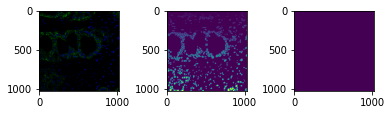

In [22]:
test_img = io.imread('/data112/NeurISP2022-CellSeg/TuningSet/cell_00043.png')
test_mask = io.imread('/data112/wzy/NIPS/baseline/work_dir/output/cell_00043_label.tiff')      
test_mask1 = io.imread('/data112/wzy/NIPS/baseline/work_dir/output1/cell_00043_label.tiff')      #baseline训练出的模型得到的结果

f = plt.figure()
f.subplots_adjust(hspace=0.6, wspace=0.6)
f.add_subplot(1, 3, 1)
plt.imshow(test_img)
f.add_subplot(1, 3, 2)
plt.imshow(test_mask )
f.add_subplot(1, 3, 3)
plt.imshow(test_mask1)

In [94]:
masks_dir = '/data112/wzy/NIPS/baseline/work_dir/output2/'
masks_path = os.listdir(masks_dir)
masks_path.sort()
for i,mask_path in enumerate(masks_path):
    test_mask = io.imread(os.path.join(masks_dir+mask_path))
    print('pic_{}'.format(i+1))
    print(len(np.unique(test_mask,return_index=False,return_counts=True,return_inverse=False)[0]))         #检查一下得到的mask图像中实例的数量，如果小于5会导致提交失败


pic_1
15
pic_2
43
pic_3
23
pic_4
14
pic_5
27
pic_6
25
pic_7
24
pic_8
15
pic_9
288
pic_10
82
pic_11
13
pic_12
179
pic_13
33
pic_14
25
pic_15
17
pic_16
27
pic_17
24
pic_18
35
pic_19
13
pic_20
33
pic_21
32
pic_22
28
pic_23
40
pic_24
23
pic_25
40
pic_26
57
pic_27
21
pic_28
67
pic_29
52
pic_30
47
pic_31
123
pic_32
121
pic_33
93
pic_34
85
pic_35
51
pic_36
47
pic_37
44
pic_38
94
pic_39
78
pic_40
96
pic_41
12
pic_42
14
pic_43
591
pic_44
1127
pic_45
895
pic_46
831
pic_47
1026
pic_48
1389
pic_49
669
pic_50
1089
pic_51
643
pic_52
723
pic_53
976
pic_54
1271
pic_55
1205
pic_56
1621
pic_57
823
pic_58
1087
pic_59
1375
pic_60
1195
pic_61
1257
pic_62
1285
pic_63
660
pic_64
1108
pic_65
1473
pic_66
668
pic_67
864
pic_68
727
pic_69
819
pic_70
37
pic_71
176
pic_72
1
pic_73
25
pic_74
17
pic_75
26
pic_76
15
pic_77
10
pic_78
15
pic_79
48
pic_80
37
pic_81
64
pic_82
51
pic_83
50
pic_84
36
pic_85
34
pic_86
34
pic_87
31
pic_88
15
pic_89
34
pic_90
35
pic_91
23
pic_92
33
pic_93
12
pic_94
10
pic_95
10
pic_96
37
pic_